In [1]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind

In [ ]:
!python -m atari_py.import_roms ROMS/

In [ ]:
import random
import math
import gym
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import deque

import tensorflow as tf
tf.enable_eager_execution()

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten

In [4]:
class DQN:
    def __init__(self,
                 env_name,
                 episodes = 15000,
                 max_replay_size = 100000,
                 min_replay_size = 10000,
                 batch_size = 32,
                 gamma = 0.99,
                 model_update_period = 2,
                 target_model_update_period = 2500,
                 final_running_av_reward = 40.0,
                 eps_min = 0.1,
                 explore_steps = 200000):
    
        env = make_atari(env_name)
        self.env = wrap_deepmind(env, frame_stack=True, scale=False)
        self.actions_num = self.env.action_space.n
    
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.copy_weights()
        
        self.optimizer = Adam(learning_rate=0.00025, clipnorm=1.0)
        self.loss_fun = tf.keras.losses.Huber()
        
        self.max_replay_size = max_replay_size
        self.state_buffer = []
        self.next_state_buffer = []
        self.reward_buffer = []
        self.done_buffer = []
        self.action_buffer = []
               
        self.eps_min = eps_min
        self.min_replay_size = min_replay_size
        self.episodes = episodes
        self.batch_size = batch_size
        self.gamma = gamma
        self.model_update_period = model_update_period
        self.target_model_update_period = target_model_update_period
        self.final_running_av_reward = final_running_av_reward
        self.explore_steps = explore_steps
        
        self.episode_rewards = []
        self.max_q_values = []
    
    def create_model(self):
        model = Sequential()
        model.add(Conv2D(32, 8, strides=(4, 4), activation="relu", input_shape=(84, 84, 4,)))
        model.add(Conv2D(64, 4, strides=(2, 2), activation="relu"))
        model.add(Conv2D(64, 3, strides=(1, 1), activation="relu"))
        
        model.add(Flatten())
        model.add(Dense(512, activation="relu"))
        model.add(Dense(self.actions_num))
        return model
    
    def copy_weights(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def sample_from_replay(self):
        indices = np.random.choice(range(len(self.done_buffer)), size=self.batch_size)
        states_sample = [self.state_buffer[i] for i in indices]
        next_states_sample = [self.next_state_buffer[i] for i in indices]
        actions_sample = [self.action_buffer[i] for i in indices]
        rewards_sample = [self.reward_buffer[i] for i in indices]
        dones_sample = [float(self.done_buffer[i]) for i in indices]
        return (np.array(states_sample).astype(np.float32) / 255.0, 
                np.array(actions_sample, dtype=np.uint8), 
                np.array(rewards_sample, dtype=np.short), 
                np.array(next_states_sample).astype(np.float32) / 255.0, 
                np.array(dones_sample))
        
    def train(self):
        states, actions, rewards, next_states, dones = self.sample_from_replay()
        
        future_q_values = self.target_model.predict(next_states)   
        target_q_values = rewards + self.gamma * np.amax(future_q_values, axis=1)
        target_q_values = target_q_values * (1 - dones) - dones
        
        masks = tf.one_hot(actions, self.actions_num)

        with tf.GradientTape() as tape:
            cur_q_values = self.model(states)
            q_values_for_actions = tf.reduce_sum(tf.multiply(cur_q_values, masks), axis=1)
            loss = self.loss_fun(target_q_values, q_values_for_actions)

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    
    def run(self):
        steps_num = 0

        eps=1.
        eps_dec=(1.-self.eps_min)/self.explore_steps

        start_time = time.time()
        
        try:
            for episode_num in range(self.episodes):
                episode_reward = 0.
                done = False
                max_q_values_sum = 0.
                episode_steps_num = 0
                
                state = self.env.reset()     
                
                while not done:
                    q_values = self.model(np.expand_dims(np.array(state).astype(np.float32) / 255.0, axis=0)).numpy()[0]
                    max_q_values_sum += np.max(q_values)
                    
                    if len(self.done_buffer) < self.min_replay_size or random.random() <= eps:
                        action = self.env.action_space.sample()
                    else:
                        action = np.argmax(q_values)

                    # env.render()
                    next_state, reward, done, _ = self.env.step(action)     
                    
                    steps_num += 1
                    episode_steps_num += 1
                    episode_reward += reward

                    self.state_buffer.append(state)
                    self.next_state_buffer.append(next_state)
                    self.reward_buffer.append(reward)
                    self.done_buffer.append(done)
                    self.action_buffer.append(action)
                    
                    state = next_state

                    if len(self.done_buffer) >= self.min_replay_size:        
                        if steps_num % self.model_update_period == 0:
                            self.train()

                        if steps_num % self.target_model_update_period == 0:
                            self.copy_weights()
                            
                        if eps > self.eps_min:
                            eps -= eps_dec
                            eps = max(self.eps_min, eps)

                    if len(self.done_buffer) > self.max_replay_size:
                        del self.state_buffer[:1]
                        del self.next_state_buffer[:1]
                        del self.reward_buffer[:1]
                        del self.done_buffer[:1]
                        del self.action_buffer[:1]
                        
                self.episode_rewards.append(episode_reward)
                self.max_q_values.append(max_q_values_sum / episode_steps_num)

                running_av_reward = np.array(self.episode_rewards[max(0, episode_num-100):]).mean()
                if episode_num % 100 == 0 and episode_num != 0:
                    cur_time = time.time()
                    print("episode:", episode_num, "; time :", int(cur_time - start_time), "seconds", "; eps:", round(eps, 2),
                          "\naverage total clipped reward for last 100 episodes:", round(running_av_reward, 4))     
                    print("-------------------------------------------------------------------------")
                    start_time = cur_time
                if running_av_reward > self.final_running_av_reward:
                    break

        finally:
            self.env.close()

    def test(self, eps=0.02):
        state = self.env.reset()
        while not done:
            if random.random() <= eps:
                action = self.env.action_space.sample()
            else:
                action = np.argmax(self.model(np.expand_dims(np.array(state).astype(np.float32) / 255.0, axis=0)).numpy()[0])
            env.render()
            state, _, done, _ = self.env.step(action)
        self.env.close()
            
    def save(self, agent_num = '0'):
        with open('results/rewards' + agent_num, 'w') as f:
            np.savetxt(f, self.episode_rewards)
        with open('results/qs' + agent_num, 'w') as f:
            np.savetxt(f, self.max_q_values)
        self.model.save('results/model' + agent_num)
        
    def restore_model(self, agent_num = '0'):
        self.model = load_model('results/model' + agent_num)

In [ ]:
agent1 = DQN('BreakoutNoFrameskip-v4')
agent1.run()
agent1.save('5')

In [7]:
agent1.save('5')

In [ ]:
agent2 = DQN('BreakoutNoFrameskip-v4',
             max_replay_size = 200000,
             min_replay_size = 20000,
             episodes = 10000,
             batch_size = 32,
             gamma = 0.99,
             model_update_period = 4,
             target_model_update_period = 5000,
             final_running_av_reward = 40.0,
             eps_min = 0.1,
             explore_steps = 300000)
agent2.run()
agent2.save('6')

episode: 100 ; time : 39 seconds ; eps: 1.0 
average total clipped reward for last 100 episodes: 0.2871
-------------------------------------------------------------------------
episode: 200 ; time : 37 seconds ; eps: 1.0 
average total clipped reward for last 100 episodes: 0.3762
-------------------------------------------------------------------------
episode: 300 ; time : 35 seconds ; eps: 1.0 
average total clipped reward for last 100 episodes: 0.297
-------------------------------------------------------------------------
episode: 400 ; time : 39 seconds ; eps: 1.0 
average total clipped reward for last 100 episodes: 0.3861
-------------------------------------------------------------------------
episode: 500 ; time : 37 seconds ; eps: 1.0 
average total clipped reward for last 100 episodes: 0.3663
-------------------------------------------------------------------------
episode: 600 ; time : 59 seconds ; eps: 0.99 
average total clipped reward for last 100 episodes: 0.3168
------

episode: 4700 ; time : 281 seconds ; eps: 0.38 
average total clipped reward for last 100 episodes: 1.901
-------------------------------------------------------------------------
episode: 4800 ; time : 264 seconds ; eps: 0.36 
average total clipped reward for last 100 episodes: 1.7228
-------------------------------------------------------------------------
episode: 4900 ; time : 303 seconds ; eps: 0.33 
average total clipped reward for last 100 episodes: 2.099
-------------------------------------------------------------------------
episode: 5000 ; time : 366 seconds ; eps: 0.29 
average total clipped reward for last 100 episodes: 2.7723
-------------------------------------------------------------------------
episode: 5100 ; time : 380 seconds ; eps: 0.25 
average total clipped reward for last 100 episodes: 2.8911
-------------------------------------------------------------------------
episode: 5200 ; time : 444 seconds ; eps: 0.21 
average total clipped reward for last 100 episode

episode: 9300 ; time : 799 seconds ; eps: 0.1 
average total clipped reward for last 100 episodes: 9.6238
-------------------------------------------------------------------------
episode: 9400 ; time : 869 seconds ; eps: 0.1 
average total clipped reward for last 100 episodes: 8.8713
-------------------------------------------------------------------------
episode: 9500 ; time : 1476 seconds ; eps: 0.1 
average total clipped reward for last 100 episodes: 9.8614
-------------------------------------------------------------------------
episode: 9600 ; time : 1448 seconds ; eps: 0.1 
average total clipped reward for last 100 episodes: 9.6337
-------------------------------------------------------------------------


In [2]:
def load_all_stats():
    all_rewards = []
    all_qs = []
    for agent in range(5):
        with open('results/rewards'+str(agent), 'r') as f:
            rewards = np.loadtxt(f)
            all_rewards.append(rewards)
        with open('results/qs'+str(agent), 'r') as f:
            qs = np.loadtxt(f)
            all_qs.append(qs)
    return all_rewards, all_qs

In [5]:
all_rewards, all_qs = load_all_stats()

In [6]:
def make_plots(rewards, q_values): 
    max_episodes = len(max(rewards, key=len))
    r_means = []
    q_means = []
    for i in range(max_episodes):
        r_sum = 0.
        r_num = 0
        q_sum = 0.
        q_num = 0
        for j in range(len(rewards)):
            if i < len(rewards[j]):
                r_sum += rewards[j][i]
                r_num += 1
            if i < len(q_values[j]):
                q_sum += q_values[j][i]
                q_num += 1
        r_means.append(r_sum/r_num)
        q_means.append(q_sum/q_num)
    
    
    plt.title("Average episode total rewards for 9 agents")
    plt.xlabel("episode")
    plt.ylabel("reward")
    plt.plot(r_means)
    plt.show()
    
    plt.title("Average Max Q-value for 9 agents")
    plt.xlabel("episode")
    plt.ylabel("q-value")
    plt.plot(q_means)
    plt.show()

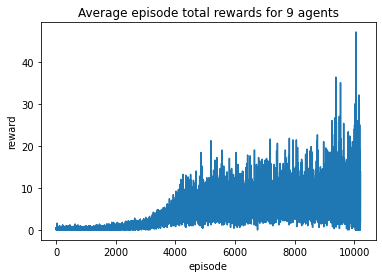

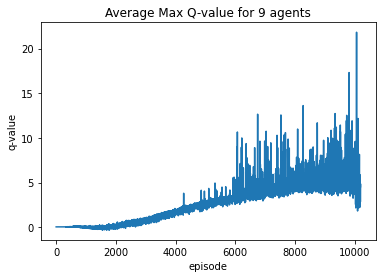

In [7]:
make_plots(all_rewards, all_qs)